In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings("ignore")

## Illustration of Wasserstein Distance and Barycenters

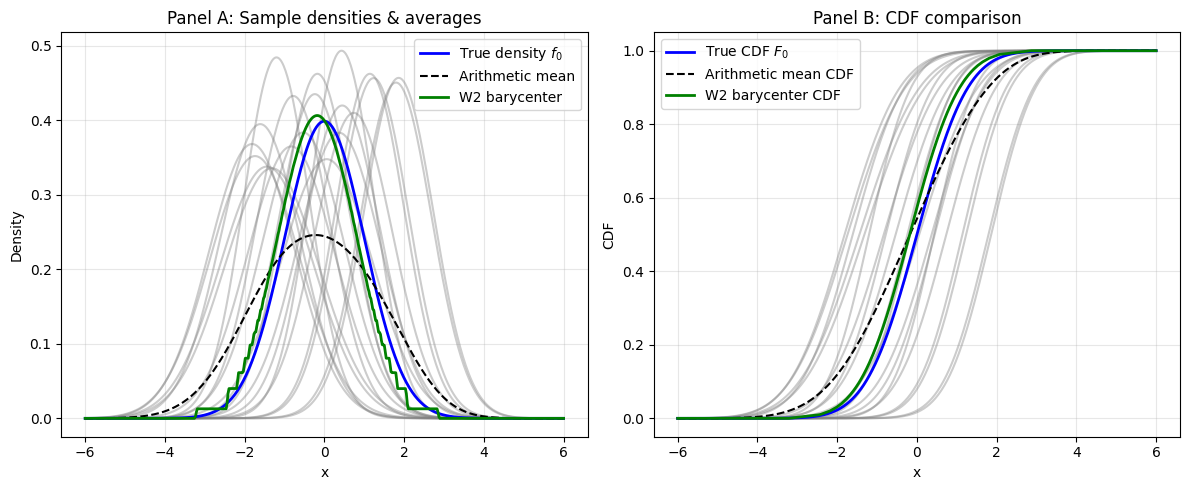

In [2]:
# --- Base distribution ---
f0 = norm.pdf
F0 = norm.cdf
q0 = norm.ppf

# --- Generate random (a,b) for location-scale model ---
n = 20
np.random.seed(42)
a = np.random.uniform(0.8, 1.2, size=n)   # scales
b = np.random.uniform(-2, 2, size=n)      # shifts

x = np.linspace(-6, 6, 500)
densities, cdfs = [], []

for i in range(n):
    fi = (1/a[i]) * f0((x - b[i]) / a[i])
    Fi = norm.cdf((x - b[i]) / a[i])
    densities.append(fi)
    cdfs.append(Fi)

densities = np.array(densities)
cdfs = np.array(cdfs)

# Arithmetic mean density & CDF
f_mean = densities.mean(axis=0)
F_mean = cdfs.mean(axis=0)

# Wasserstein barycenter via quantile averaging
u = np.linspace(0.001, 0.999, 100)
quantiles = np.array([a[i] * q0(u) + b[i] for i in range(n)])
q_bar = np.mean(quantiles, axis=0)

F_bar = np.interp(x, q_bar, np.linspace(0, 1, len(q_bar)))
f_bar = np.gradient(F_bar, x)

# True base
f_true = f0(x)
F_true = F0(x)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: sample densities
for fi in densities:
    axes[0].plot(x, fi, color="gray", alpha=0.4)
axes[0].plot(x, f_true, color="blue", linewidth=2, label="True density $f_0$")
axes[0].plot(x, f_mean, color="black", linestyle="--", label="Arithmetic mean")
axes[0].plot(x, f_bar, color="green", linewidth=2, label="W2 barycenter")
axes[0].set_title("Panel A: Sample densities & averages")
axes[0].set_xlabel("x"); axes[0].set_ylabel("Density")
axes[0].legend(); axes[0].grid(alpha=0.3)


# Panel B: CDFs
for Fi in cdfs:
    axes[1].plot(x, Fi, color="gray", alpha=0.4)
axes[1].plot(x, F_true, color="blue", linewidth=2, label="True CDF $F_0$")
axes[1].plot(x, F_mean, color="black", linestyle="--", label="Arithmetic mean CDF")
axes[1].plot(x, F_bar, color="green", linewidth=2, label="W2 barycenter CDF")
axes[1].set_title("Panel B: CDF comparison")
axes[1].set_xlabel("x"); axes[1].set_ylabel("CDF")
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
from src.clustering_methods import WassersteinKMeans, MomentKMeans, HMMClustering
from src.utils import *
from src.constants import CLUSTER_PALETTE
CLUSTER_PALETTE[1], CLUSTER_PALETTE[2] = CLUSTER_PALETTE[2], CLUSTER_PALETTE[1]

## Example of Regime Segmentation Using Wasserstein K-Means / Moment K-Means / HMM Using Synthetic Data

### Simple Synthetic Distributions (two regimes: low vs high variance)

In [4]:
# Example: synthetic distributions (two regimes: low vs high variance)
rng = np.random.default_rng(0)

X = []
for _ in range(30):
    X.append(rng.normal(.3, 1, size=100))   # regime 1
for _ in range(30):
    X.append(rng.normal(-.3, 1.2, size=100))   # regime 2

#### Wasserstein K-Means Clustering Results

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Label counts: [30 30]


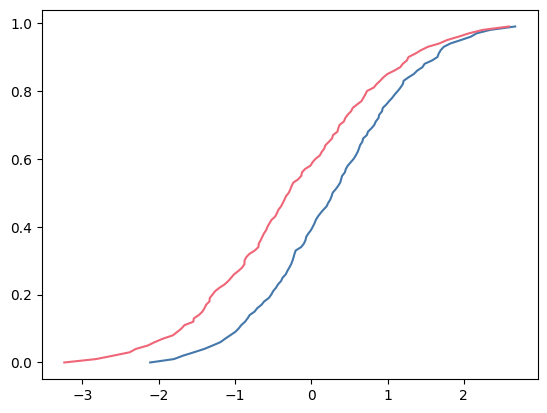

4 [np.float64(0.4591610328799746), np.float64(0.21974828972730792), np.float64(0.025130352470695422), np.float64(0.0)]


In [5]:
wkmeans = WassersteinKMeans(n_clusters=2, p_dim=1, random_state=42)
result = wkmeans.fit(X)

print("Cluster labels:", result.labels)
print("Label counts:", np.bincount(result.labels))

plt.plot(result.centroids[0], np.arange(len(result.centroids[0])) / len(result.centroids[0]), label="Centroid 1", color=CLUSTER_PALETTE[0])
plt.plot(result.centroids[1], np.arange(len(result.centroids[1])) / len(result.centroids[1]), label="Centroid 2", color=CLUSTER_PALETTE[1])
plt.show()

print(result.iter, result.losses)

#### Moment K-Means Clustering Results

In [6]:
mkmeans = MomentKMeans(n_clusters=2, p_dim=2, random_state=42)
result = mkmeans.fit(X)

print("Cluster labels:", result.labels)
print("Label counts:", np.bincount(result.labels))

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Label counts: [30 30]


### Synthetic Price Data Regime Segmentation Example

In [7]:
# Synthetic demo: two regimes (low vol vs high vol)
rng = np.random.default_rng(1)
n_points = 1000
returns = np.concatenate([
    rng.normal(0, 0.01, size=n_points // 2),
    rng.normal(0, 0.05, size=n_points // 2),
])
returns = pd.Series(returns)
prices = 100 * np.exp(np.cumsum(returns))
prices = np.concat([np.array([100]), prices])

# Segment returns
window, step = 50, 25
segments = segment_time_series(returns, window, step)

#### Wasserstein K-Means Clustering Results

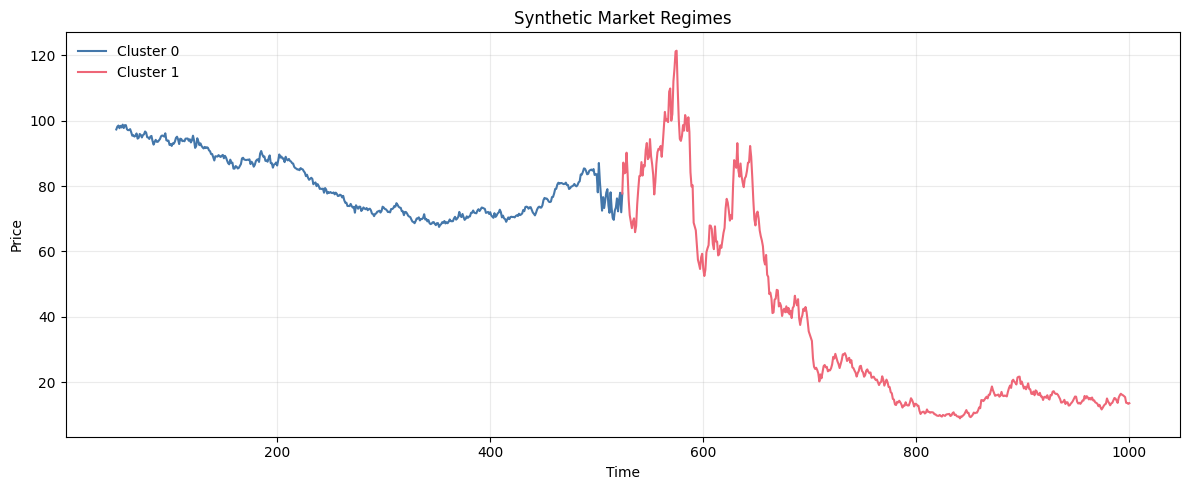

In [8]:
# Fit WK-means
wkmeans = WassersteinKMeans(n_clusters=2, p_dim=2, random_state=42)
result = wkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, result.labels, title="Synthetic Market Regimes")

#### Moment K-Means Clustering Results

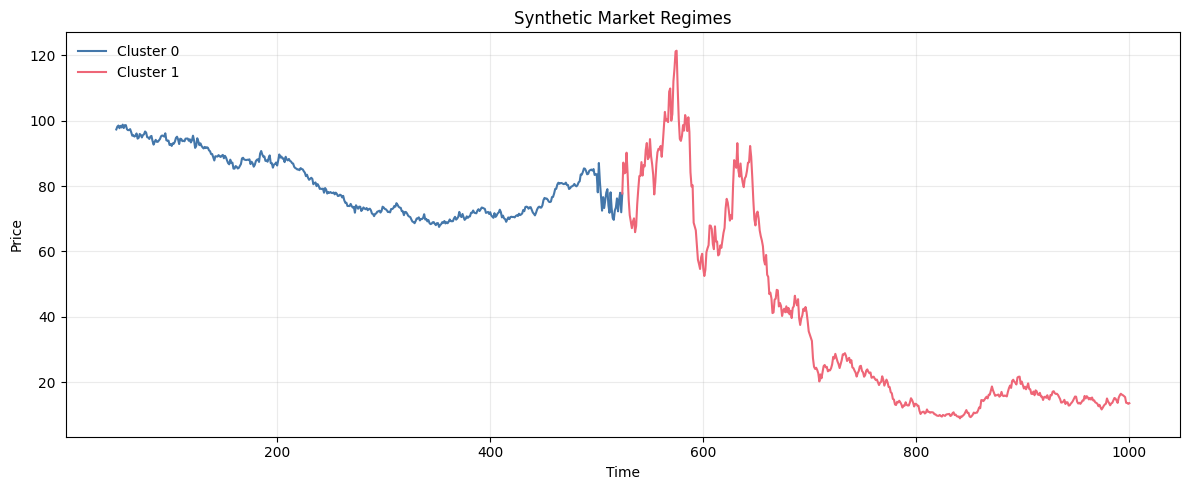

In [9]:
# Fit MK-means
mkmeans = MomentKMeans(n_clusters=2, p_dim=2, random_state=42)
result = mkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, result.labels, title="Synthetic Market Regimes")

#### Hidden Markov Model Clustering Results

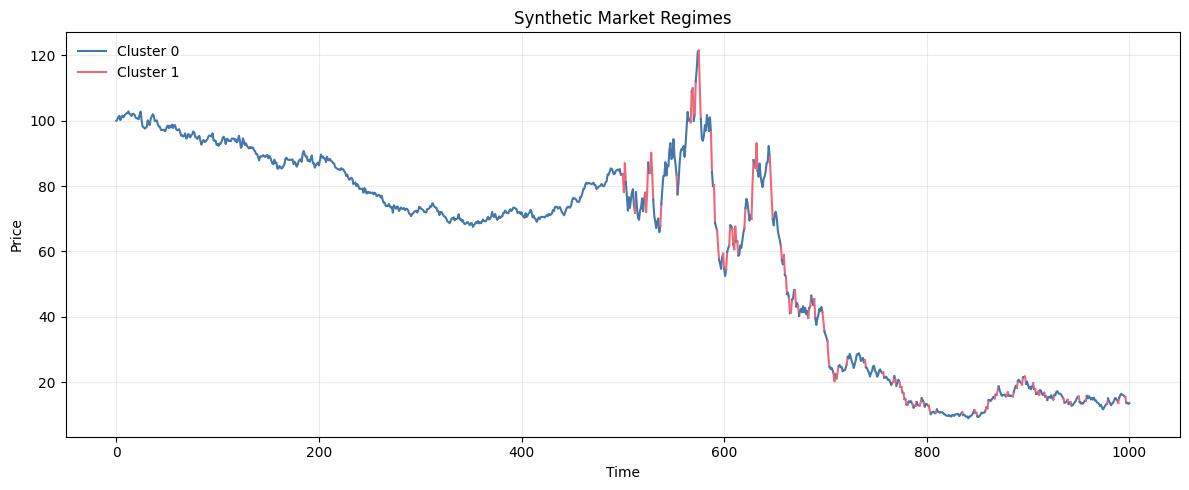

In [10]:
# Fit HMM clustering
hmm_cluster = HMMClustering(n_states=2, random_state=42)
result = hmm_cluster.fit(returns)

# Plot regimes
plot_regimes_over_price(prices, result.labels, title="Synthetic Market Regimes")

### Jump Diffusion Synthetic Data Regime Segmentation Example

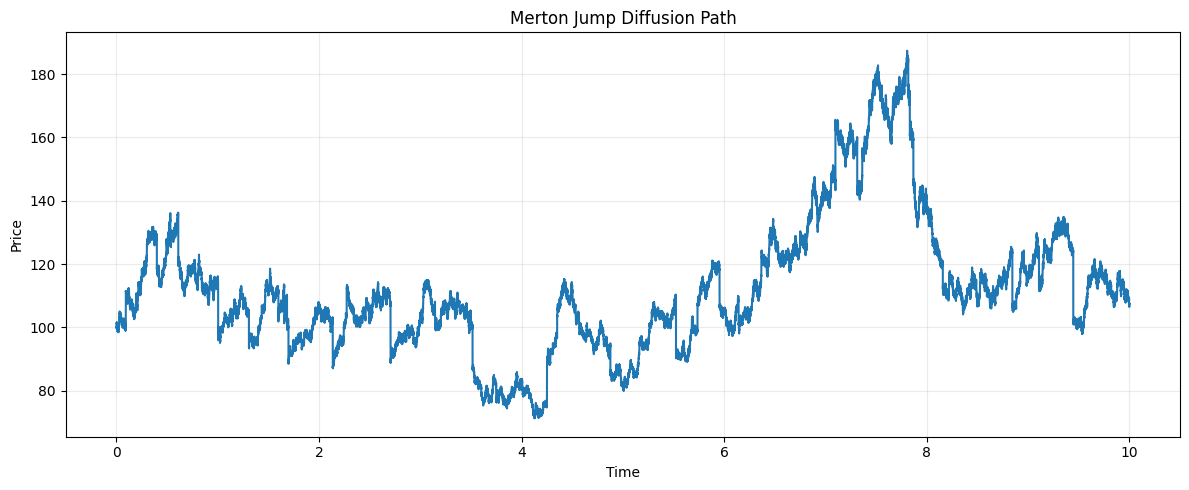

In [11]:
from src.jump_diffusion import simulate_merton_jump_diffusion
times, prices, jumps = simulate_merton_jump_diffusion(T=10.0, N=252 * 10 * 24, random_state=42)

prices = pd.Series(prices, times)
returns = np.log(prices).diff().dropna()
window, step = 360, 12
segments = segment_time_series(returns, window, step)

plt.figure(figsize=(12, 5))
plt.plot(times, prices)
plt.grid(alpha=0.25)
plt.title("Merton Jump Diffusion Path")
plt.xlabel("Time")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

#### Wasserstein K-Means Clustering Results

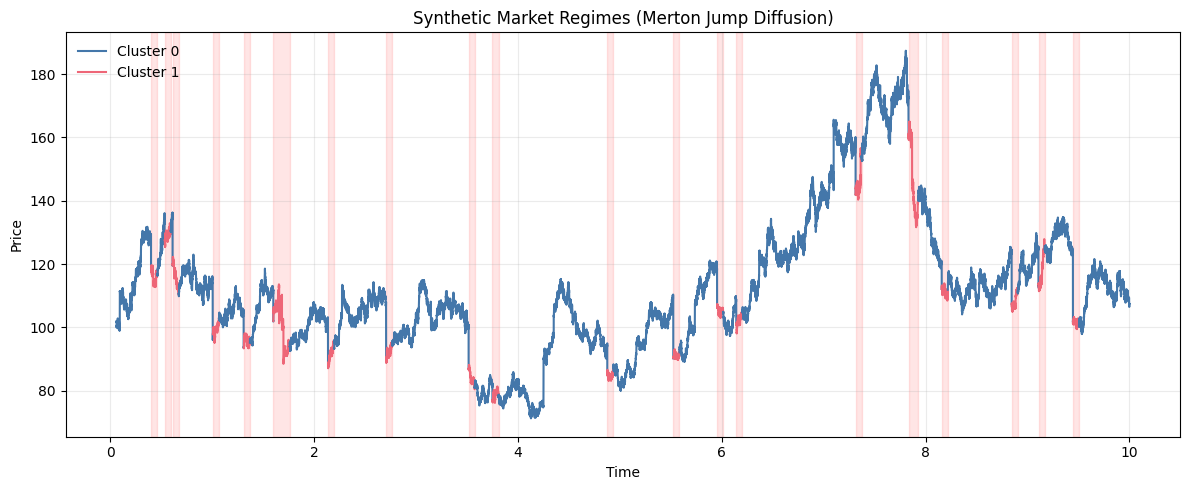

In [12]:
# Fit WK-means
wkmeans = WassersteinKMeans(n_clusters=2, p_dim=2, random_state=42)
result = wkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, result.labels, title="Synthetic Market Regimes (Merton Jump Diffusion)", highlight_clusters=[1])

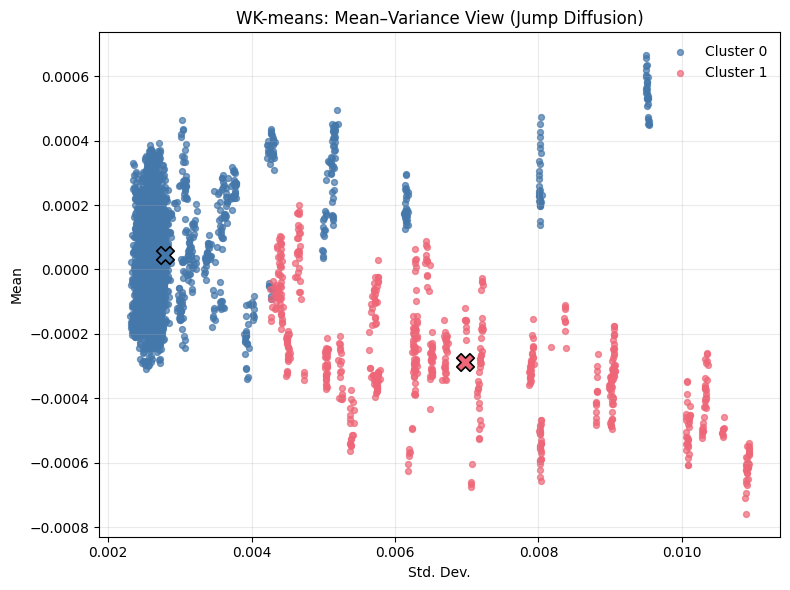

# of jumps: 48
Centroid means: [np.float64(4.583e-05), np.float64(-0.0002873)]
Centroid stds: [np.float64(0.00264645), np.float64(0.00679745)]
Label counts: [4342  669]


In [13]:
scatter_mean_variance(
    segments,
    result.labels,
    title="WK-means: Mean–Variance View (Jump Diffusion)",
)

print("# of jumps:", jumps)
print("Centroid means:", [round(x.mean(), 8) for x in result.centroids])
print("Centroid stds:", [round(x.std(), 8) for x in result.centroids])
print("Label counts:", np.bincount(result.labels))

#### Moment K-Means Clustering Results

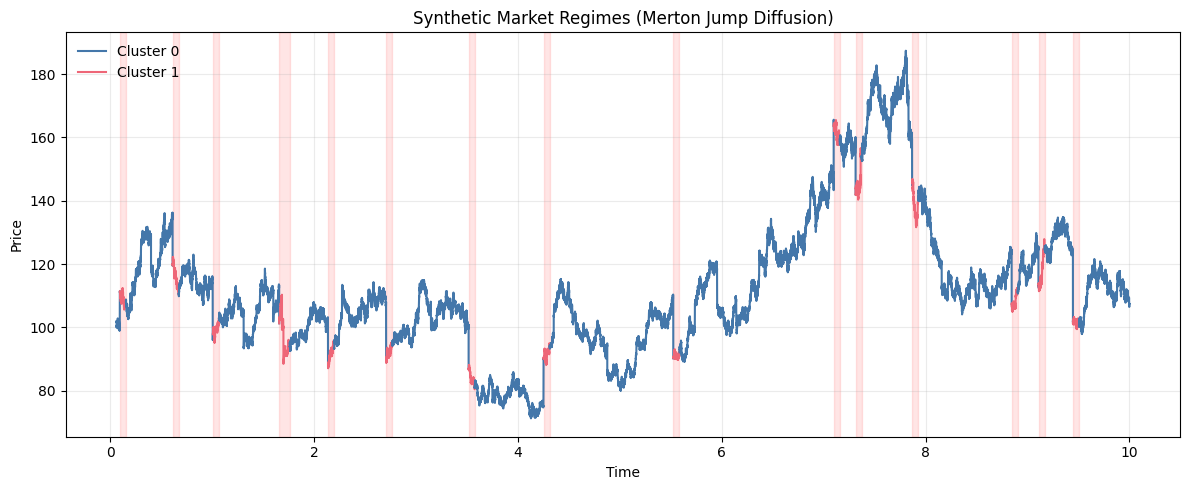

In [14]:
mkmeans = MomentKMeans(n_clusters=2, p_dim=2, random_state=42)
result = mkmeans.fit(segments)

plot_regimes_over_price(prices, result.labels, title="Synthetic Market Regimes (Merton Jump Diffusion)", highlight_clusters=[1])

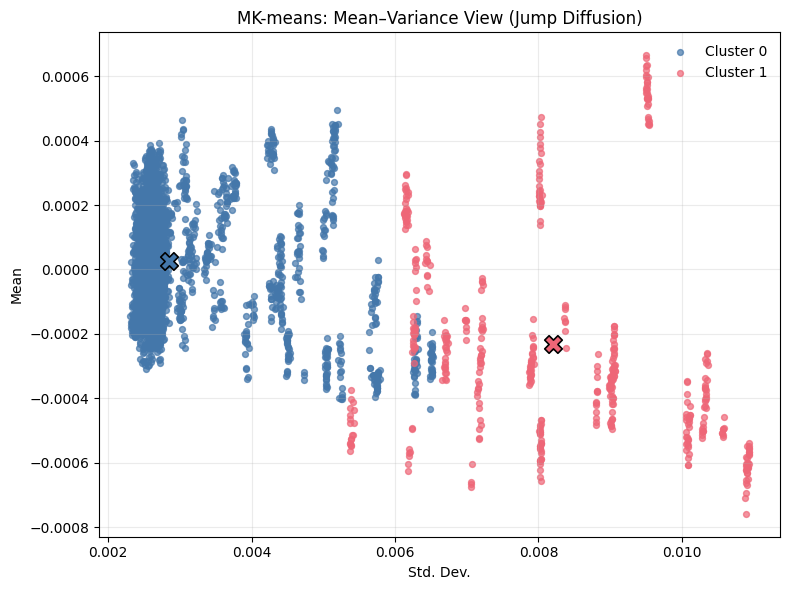

# of jumps: 48
Centroid means: [ 0.00557628 -0.05362447]
Centroid stds: [0.32586317 2.1745913 ]
Label counts: [4539  472]


In [15]:
scatter_mean_variance(
    segments,
    result.labels,
    title="MK-means: Mean–Variance View (Jump Diffusion)",
)

print("# of jumps:", jumps)
print("Centroid means:", result.centroids[:, 0])
print("Centroid stds:", result.centroids[:, 1])
print("Label counts:", np.bincount(result.labels))

## Real Financial Data Regime Segmentation Example (SPX)

In [16]:
CLUSTER_PALETTE[1], CLUSTER_PALETTE[2] = CLUSTER_PALETTE[2], CLUSTER_PALETTE[1]
signal_df = load_signal("../data/SPX_hourly.csv")
prices = signal_df["Close"]
log_returns = np.log(prices).diff().dropna()

window, step = 360, 12
segments = segment_time_series(log_returns, window=window, step=step)

#### Wasserstein K-Means Clustering Results

# of points in cluster 0 : 4354
# of points in cluster 1 : 2845
# of points in cluster 2 : 1200


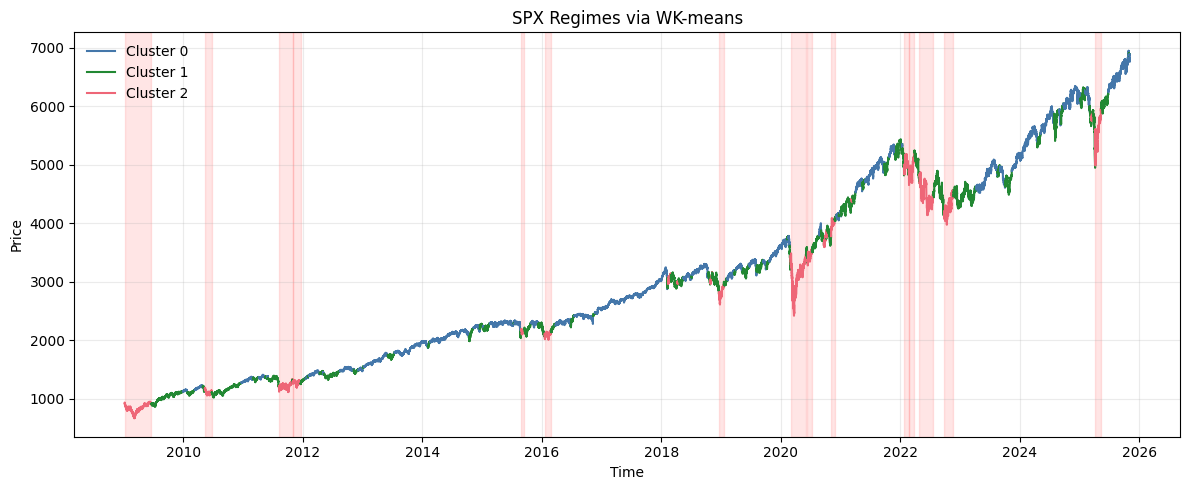

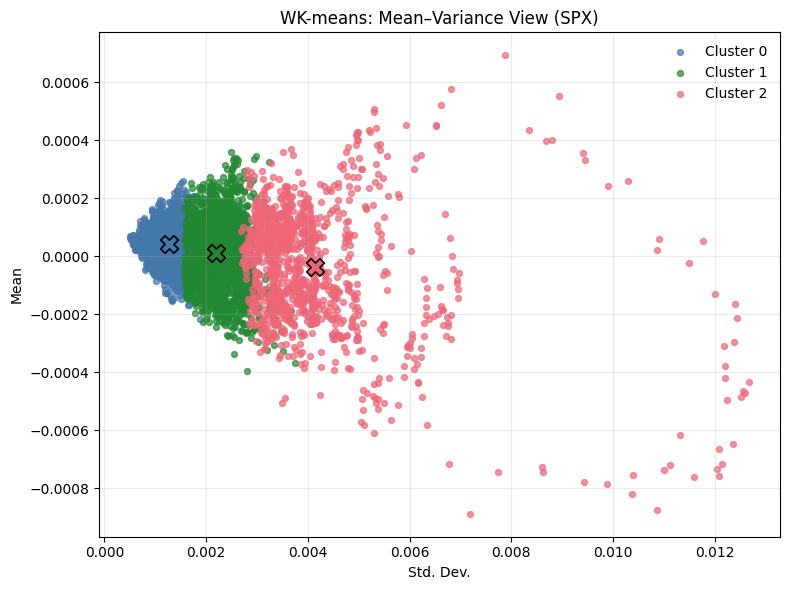

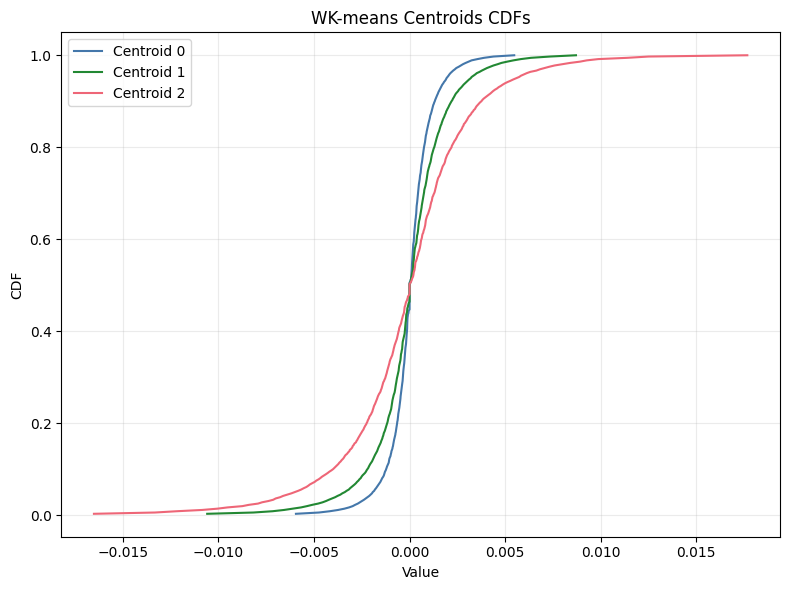

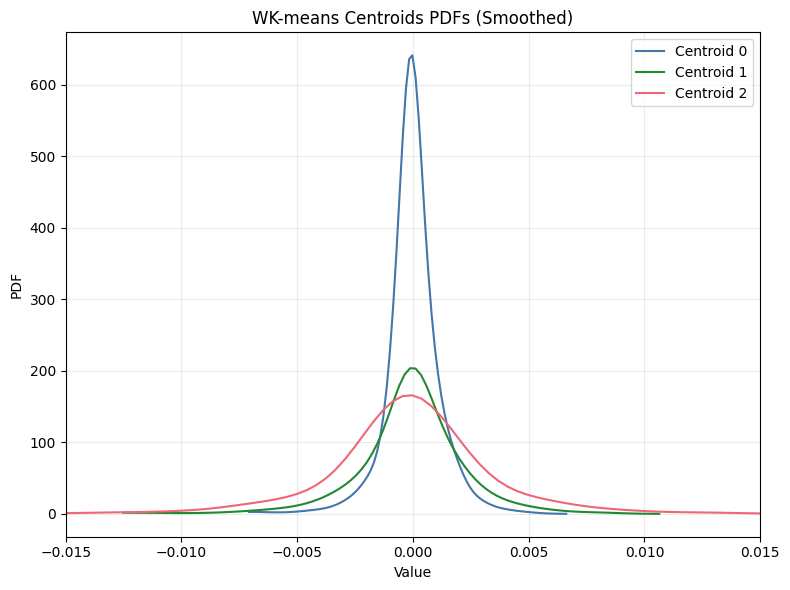

In [17]:
wk = WassersteinKMeans(n_clusters=3, p_dim=1, random_state=42)
result = wk.fit(segments)

for i, cnt in enumerate(np.bincount(result.labels)):
    print("# of points in cluster", i, ":", cnt)

plot_regimes_over_price(
    prices,
    result.labels,
    title="SPX Regimes via WK-means",
    highlight_clusters=[2],
    highlight_min_width=300
)
scatter_mean_variance(
    segments,
    result.labels,
    title="WK-means: Mean–Variance View (SPX)",
)

wk.plot_centroids_cdf()
wk.plot_centroids_pdf(xlim=(-0.015, 0.015))

#### Moment K-Means Clustering Results

# of points in cluster 0 : 7521
# of points in cluster 1 : 839
# of points in cluster 2 : 39


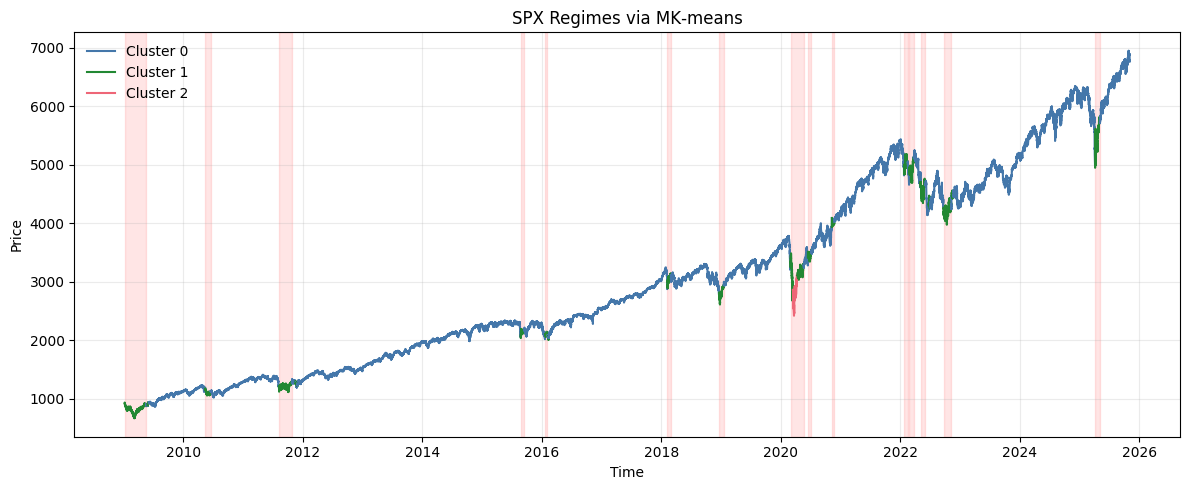

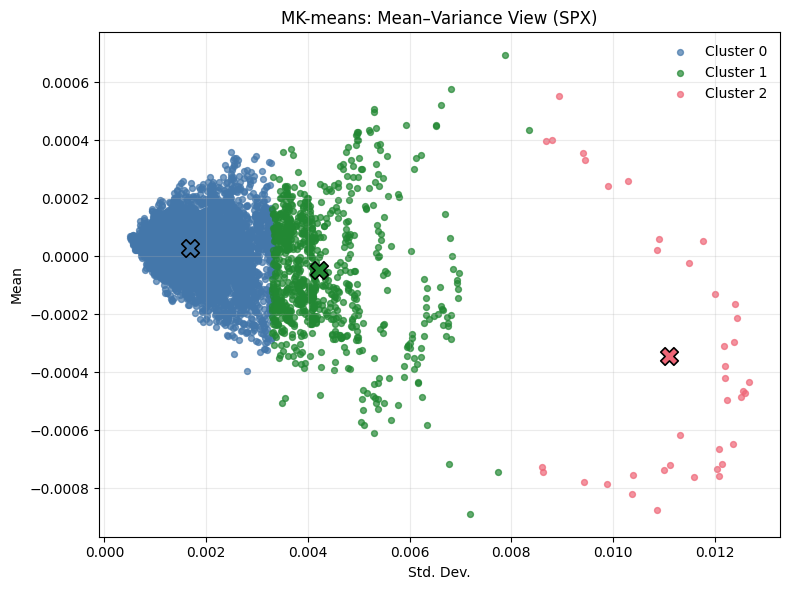

In [18]:
mk = MomentKMeans(n_clusters=3, p_dim=2, random_state=42)
result = mk.fit(segments)

for i, cnt in enumerate(np.bincount(result.labels)):
    print("# of points in cluster", i, ":", cnt)

plot_regimes_over_price(prices, result.labels, title="SPX Regimes via MK‐means", highlight_clusters=[1, 2], highlight_min_width=150)
scatter_mean_variance(
    segments,
    result.labels,
    title="MK-means: Mean–Variance View (SPX)",
)

#### Hidden Markov Model Clustering Results

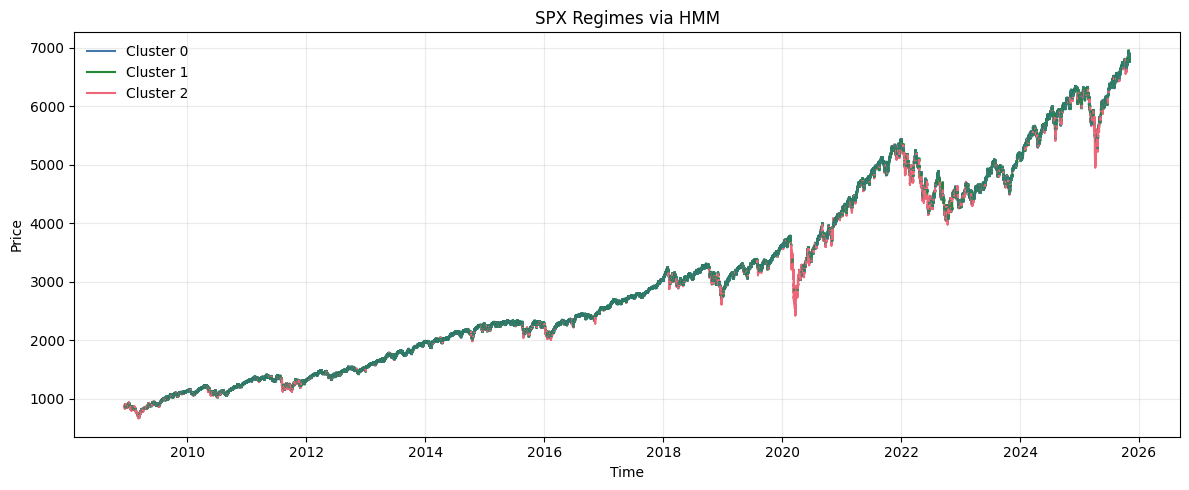

# of points in cluster 0 : 42317
# of points in cluster 1 : 42589
# of points in cluster 2 : 16232


In [19]:
hmm = HMMClustering(n_states=3, random_state=42)
result = hmm.fit(log_returns.dropna())

plot_regimes_over_price(prices, result.labels, title="SPX Regimes via HMM")

for i, cnt in enumerate(np.bincount(result.labels)):
    print("# of points in cluster", i, ":", cnt)